# Weather Image Recognition

In this notebook I am going to create a weather image recognition system. The goal is to take an image as input and to return the weather prediction. For training, I use the Weather Image Recognition dataset from Kaggle (link: https://www.kaggle.com/jehanbhathena/weather-dataset). <br> <br>
I plan to investigate the following topics: <br>
- Plot data distribution and investigate the dataset
- Create train-test split to already have hold out test set.
- Create input pipeline for CNN training using tensorflow's ImageDataGenerator class (with only some basic augmentations like 
   flipping in the beginning).
- Train different state-of-the-art CNN architectures on the trainining set and compare their performance on the validation set. Use threef old cross validation. Also: Create own CNN architecture (nice to also keep important things in mind about CNN architectures!). 
- Add data augmentations to improve performance (check which augmentations fit in different notebook)
- Try different image sizes to find the optimal one.
- Try different imbalance strategies.
- Use Bayesian Hyperparameter Search to optimize hyperparameters.
- Test final model on hold-out test set to check distribution on real world data.

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow_addons as tfa
import glob
import csv
import imgaug.augmenters as iaa
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = [8,8]

In [2]:
# check if GPU is recognized
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# set global important variables
NUM_CLASSES = 11

# Load Data

In [4]:
path = 'dataset'
path_imgs = list( map(lambda x: x.replace("dataset"+os.path.sep, ""), list(glob.glob(path+'/**/*.jpg'))))
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='filepath').astype(str)
labels = pd.Series(labels, name='label')
df = pd.concat([file_path, labels], axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

filepath      label
0  sandstorm\3524.jpg  sandstorm
1        dew\2636.jpg        dew
2  sandstorm\2950.jpg  sandstorm
3  lightning\2161.jpg  lightning
4      frost\3606.jpg      frost

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6862 entries, 0 to 6861
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  6862 non-null   object
 1   label     6862 non-null   object
dtypes: object(2)
memory usage: 107.3+ KB


Okay perfect! In Kaggle its stated that there should be 6862 images in total, so we've read out all images. Now let's plot the data distribution to get a better understanding of the dataset.

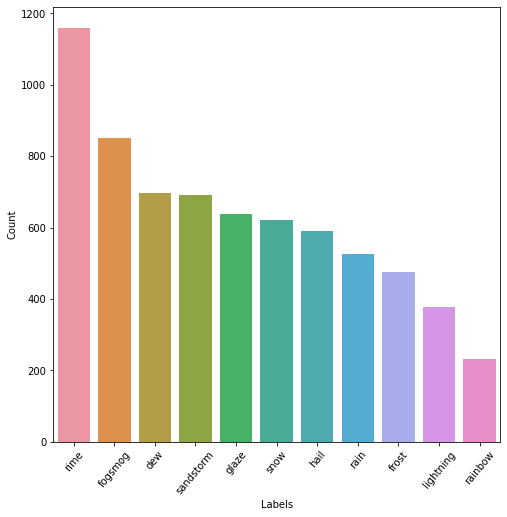

In [6]:
counts = df["label"].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=50);

Okay. The dataset is definetly imbalanced! Let's later apply some imbalance strategies to check if model performance can be improved to the model trained on the imbalanced dataset. <br> <br>
<b> IMPORTANT: </b> Don't change the distribution on the validation set and the hold-out test set! They should reflect the real data distribution! Therefore, we can first split the data into the according sets and could then later apply some imbalance strategies only on the training set.

## Plot some Images

In [7]:
def show_random_image(df, dataset_folder="dataset"):
    rand_ind = np.random.randint(0, df.shape[0])
    
    row = df.iloc[rand_ind]
    filepath = os.path.join(dataset_folder, row["filepath"])
    label = row["label"]
    
    # load image
    image = plt.imread(filepath)
    plt.imshow(image)
    plt.title(f"Class: {label}")
    plt.show()

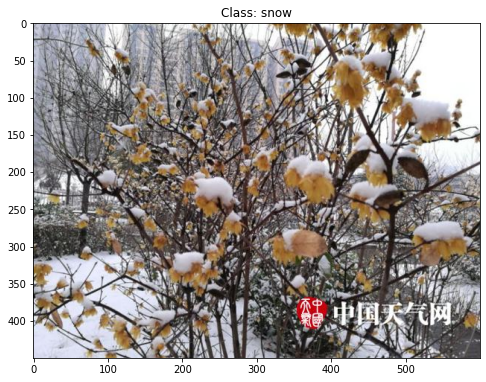

In [8]:
show_random_image(df)

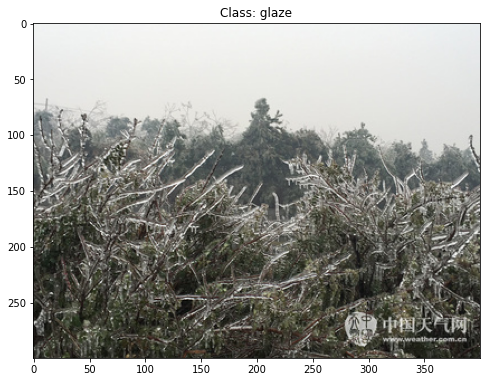

In [9]:
show_random_image(df)

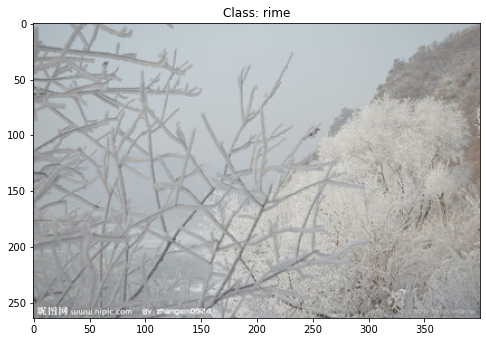

In [10]:
show_random_image(df)

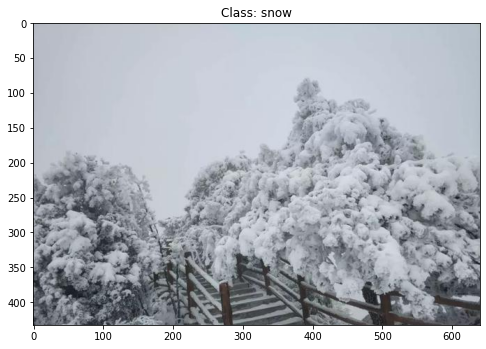

In [11]:
show_random_image(df)

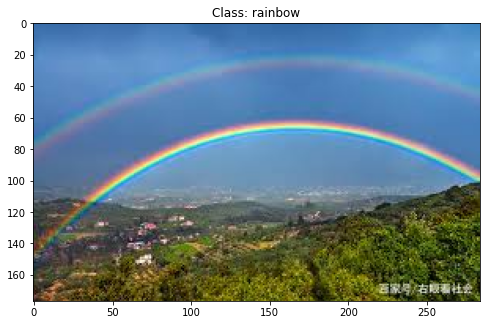

In [12]:
show_random_image(df)

## Split Data
Let's now split the data into training, test and validation sets.

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split in train and test
for train_index, test_index in sss.split(df.drop(columns="label"), df["label"]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df.iloc[train_index]
    df_test = df.iloc[test_index]

TRAIN: [1170 1870 5072 ... 4081 2161 6029] TEST: [6067  517 2991 ... 2857 1781  901]


In [9]:
# split in train and validation
df_train_tmp = df_train.copy()
for train_index, test_index in sss.split(df_train_tmp.drop(columns="label"), df_train_tmp["label"]):
    print("TRAIN:", train_index, "TEST:", test_index)
    df_train = df_train_tmp.iloc[train_index]
    df_val = df_train_tmp.iloc[test_index]

TRAIN: [3513 1304 1064 ... 3328 1793 3493] TEST: [ 257  974 3999 ... 3871 4574 4067]


In [10]:
# quickly check if number of samples of train + test still matches the total number of samples
assert df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0], "Number of samples in splits does not match"

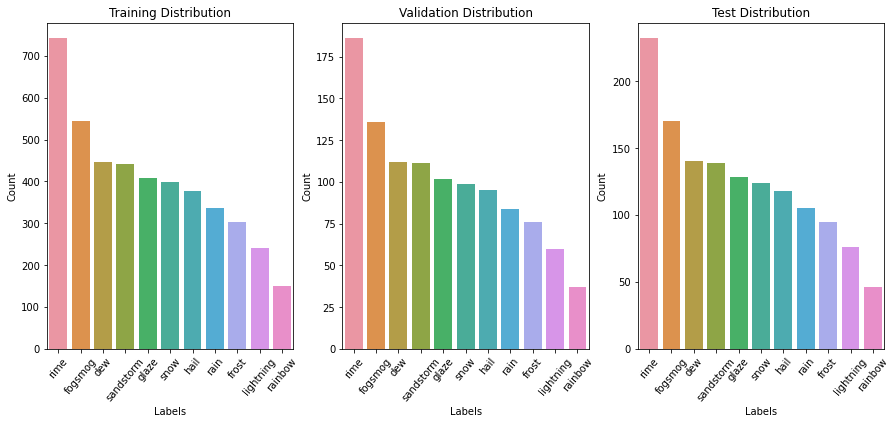

In [11]:
fig = plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
counts = df_train["label"].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Training Distribution")
plt.xticks(rotation=50);

plt.subplot(1, 3, 2)
counts = df_val["label"].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Validation Distribution")
plt.xticks(rotation=50);

plt.subplot(1, 3, 3)
counts = df_test["label"].value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title("Test Distribution")
plt.xticks(rotation=50);

## Create Input Pipeline and Check
Let's now create the input pipeline and verify that the images still look okay. Here, I first want to only use some very basic augmentations and I want to resize the images to a fixed size.

In [24]:
datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                                   rescale=1./255.)
datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_train = datagen_training.flow_from_dataframe(df_train, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=(256, 256),
                                                     color_mode="rgb",
                                                     class_mode="categorical",
                                                     batch_size=16,
                                                     seed=42)

datagen_val = datagen_test.flow_from_dataframe(df_val, 
                                             directory="dataset", 
                                             x_col="filepath",
                                             y_col="label",
                                             target_size=(256, 256),
                                             color_mode="rgb",
                                             class_mode="categorical",
                                             batch_size=16,
                                             seed=42)

Found 4391 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.


In [25]:
def show_random_image_generator(batch, label, batch_size=16):
    rand_ind = np.random.randint(0, batch_size)
    plt.imshow(batch[rand_ind], cmap='gray', vmin=0, vmax=1)
    #plt.title(f"Class label: {label}")
    plt.show()

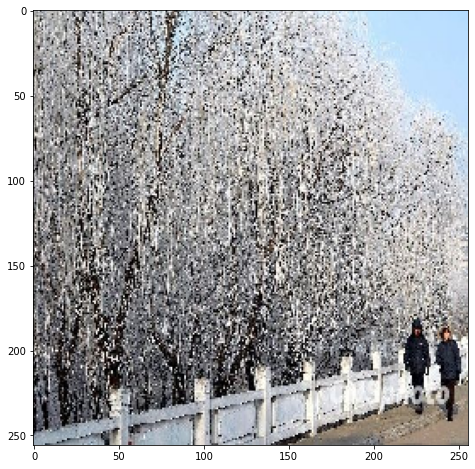

In [26]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

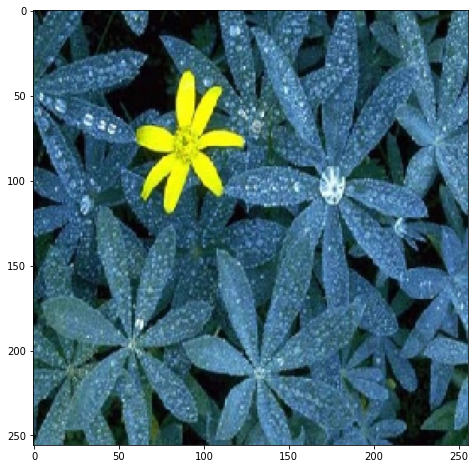

In [27]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

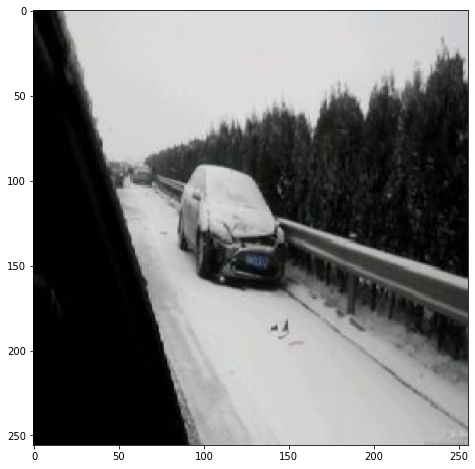

In [28]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

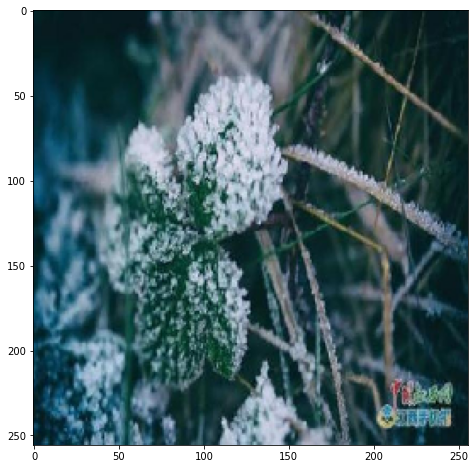

In [29]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

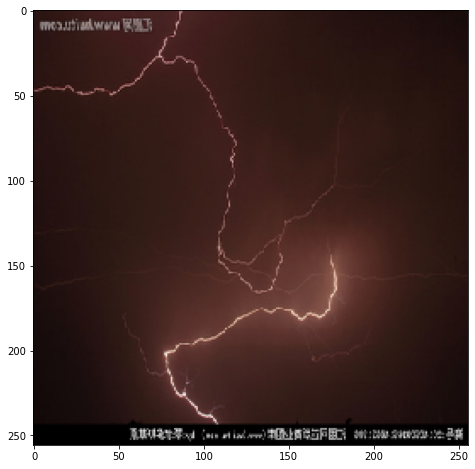

In [30]:
batch, label = next(datagen_train)
show_random_image_generator(batch, label)

Well. The input pipeline looks good. It can later be used for the training process. Let's now create an own CNN and a class with all CNNS which can be later called to compare different CNN architectures.

In [31]:
def create_custom_model(input_shape, num_classes=NUM_CLASSES):
    X_input = tf.keras.Input(input_shape, name="Input")
    
    X = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=2, padding="same")(X_input)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=2, padding="same")(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X_reduced = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    
    X = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=2, padding="same")(X_reduced)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding="same")(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    X = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X)
    
    X = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=2, padding="same")(X)
    X = tf.keras.layers.ReLU()(X)
    X = tf.keras.layers.BatchNormalization()(X)
    
    # add output part
    X = tf.keras.layers.Flatten()(X)
    X = tf.keras.layers.Dense(128, activation="relu")(X)
    X = tf.keras.layers.Dense(128, activation="relu")(X)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(X)
    
    # finally: create model
    model = tf.keras.Model(inputs=X_input, outputs=predictions)
    
    return model

In [32]:
custom_model = create_custom_model(input_shape=(256, 256, 1))

In [33]:
custom_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
re_lu (ReLU)                 (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256   

Let's now create a function that takes in a model and some parameters and runs full training using that model. This is the end-to-end training pipeline.

### Model Factory Class

In [34]:
class Model_Factory():
    '''
    This class can be used to create a keras model and return it.
    '''
    def __init__(self):
        '''
        Constructor.
        '''
        pass
    
    def create_and_return_keras_model(self, model_name, num_classes, input_shape, 
                                      activation_func="softmax", transfer_learning=False):
        '''
        This function takes some information about the keras model to create and returns it. The model_name must be one
        of the following: ["efficientnetb0", "efficientnetb2", "xception", "densenet121", "resnet18", "resnet34", "custom"]
        
        Args:
            model_name (str): Name of the keras model which shall be instantiated.
            num_classes (int): The number of classes and therefore the number of output neurons.
            input_shape (tuple): Shape of input images (height, widht, depth)
            activation_func (str): Activation function that should be used on the output layer
            transfer_learning (bool): Whether to reuse the trained weights on the imagenet dataset 
                                         or to use newly initialized weights
        '''
        if (not isinstance(model_name, str)):
                raise ValueError("Input model_name has the wrong datatype!")
        
        if not isinstance(num_classes, int):
            raise ValueError("Input num_classes has the wrong datatype!")
        
        if not isinstance(transfer_learning, bool):
            raise ValueError("Input transfer_leraning has the wrong datatype!")
        
        if not isinstance(activation_func, str):
            raise ValueError("Input activation_func has the wrong datatype!")
        
        weights = "imagenet" if transfer_learning else None
        
        if model_name == "custom":
            model = create_custom_model(input_shape=input_shape, num_classes=num_classes)
        else:
            if model_name == "efficientnetb0":
                from tensorflow.keras.applications import EfficientNetB0
                model = EfficientNetB0(weights=weights, include_top=False, input_shape=input_shape)
            elif model_name == "efficientnetb2":
                from tensorflow.keras.applications import EfficientNetB2
                model = EfficientNetB2(weights=weights, include_top=False, input_shape=input_shape)
            elif model_name == "xception":
                from tensorflow.keras.applications import Xception
                model = Xception(weights=weights, include_top=False, input_shape=input_shape)
            else:
                from classification_models.tfkeras import Classifiers
                net, _ = Classifiers.get(model_name)
                model = net(input_shape=input_shape, weights=weights, include_top=False)

            # add output part
            x = model.output
            x = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(128, activation="relu")(x)
            x = tf.keras.layers.Dense(128, activation="relu")(x)

            # and a fully connected output/classification layer
            predictions = tf.keras.layers.Dense(num_classes, activation=activation_func)(x)

            # create the full network so we can train on it
            model = tf.keras.models.Model(inputs=model.input, outputs=predictions)
        
        return model

In [35]:
factory = Model_Factory()

In [36]:
def end_to_end_training(model, datagen_train, datagen_val, num_epochs, lr_val=4e-3, num_classes=NUM_CLASSES, callbacks=None):
    # create keras optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=lr_val)

    # define the metrics
    metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tfa.metrics.F1Score(num_classes=num_classes, average='weighted')
    ]

    # compile the model
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics_list)

    # fit the model for num_epochs epochs
    with tf.device("/GPU:0"):
        hist_dict = model.fit(datagen_train, epochs=num_epochs, verbose=1, validation_data=datagen_val, callbacks=callbacks)
    return hist_dict

Let's now compare all the models using the f1-score due to the imbalanced dataset. Let's train each model for a fixed number of epochs and compare the best validation f1-score. <br> <br>
I am going to use transfer learning to use maybe already useful features from imagenet learning. But transfer learning is not applied on the custom model, because this one has never been trained yet! <br> <br>
In addition, I am using the ReduceLROnPlateau callback from tensorflow in order to avoid the models from hanging in a saddle point or local minumum (happend the first time I've run this evaluation!). 

In [37]:
def create_loss_plots(results_hists_dict, figpath=r"figures\encoder_search_loss.pdf",
                      num_rows=2, num_cols=3, ylim=(0, 10)):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a loss plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
        ylim (tuple of ints): Tuple with (bottom, top) value for y-range. This is helpful to filter out outliers in loss plot.
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["loss"], label="Train")
        plt.plot(hist_dict["val_loss"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("Loss")
        plt.title(f"{key}")
        plt.ylim(ylim)
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

In [38]:
def create_f1_plots(results_hists_dict, figpath=r"figures\encoder_search_f1_score.pdf",
                    num_rows=2, num_cols=3):
    '''
    This function takes the dictionary with all training histories of the different encoders 
    and creates a f1-score plot.
    
    Args:
        results_hists_dict (dictionary): Dictionary with encoder name as key and the training history dict as value
        figpath (string): Path where the figure should be stored
        num_rows (int): Number of rows in subplot figure
        num_cols (int): Number of columns in subplot figure
    '''
    fig = plt.figure(figsize = (16, 8))
    
    # loop over different encoders and plot results
    for idx, (key, hist_dict) in enumerate(results_hists_dict.items()):
        plt.subplot(num_rows, num_cols, idx+1)
        plt.plot(hist_dict["f1_score"], label="Train")
        plt.plot(hist_dict["val_f1_score"], label="Val")
        
        if(idx >= num_cols):
            plt.xlabel("Epoch")
            
        if(idx == 0 or idx == num_cols):
            plt.ylabel("F1-Score")
        plt.title(f"{key}")
        plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

In [42]:
encoder_list = ["custom", "efficientnetb2", "xception", "densenet121", "resnet18", "resnet50"]
target_size = (256, 256)
num_epochs = 30
batch_size = 16
results_dict = dict()
results_hists_dict = dict()
img_height, img_width = target_size
color_mode = "rgb"
img_depth = 3

datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, rescale=1./255.)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_train = datagen_training.flow_from_dataframe(df_train, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)

datagen_val = datagen_valid.flow_from_dataframe(df_val, 
                                                 directory="dataset", 
                                                 x_col="filepath",
                                                 y_col="label",
                                                 target_size=target_size,
                                                 color_mode=color_mode,
                                                 class_mode="categorical",
                                                 batch_size=batch_size,
                                                 seed=42)

# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

for encoder in encoder_list:
    print(f"Start training {encoder}...")
    
            
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=NUM_CLASSES, 
                                                  input_shape=(img_height, img_width, img_depth),
                                                  activation_func="softmax",
                                                  transfer_learning=True)

    hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                    num_epochs=num_epochs, callbacks=[reduce_lr])

    # get the maximum validation f1-score and validation accuracy and store them
    results_dict[encoder] = np.max(hist_dict.history["val_f1_score"])

    # save also the history in order to make some nice visualizations
    results_hists_dict[encoder] = hist_dict.history

Found 4391 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.
Start training custom...
Epoch 1/30
275/275 [==============================] - 31s 108ms/step - loss: 1.8118 - accuracy: 0.4020 - f1_score: 0.3860 - val_loss: 1.7718 - val_accuracy: 0.4636 - val_f1_score: 0.4242
Epoch 2/30
275/275 [==============================] - 27s 99ms/step - loss: 1.4442 - accuracy: 0.5083 - f1_score: 0.4953 - val_loss: 2.3512 - val_accuracy: 0.3944 - val_f1_score: 0.3830
Epoch 3/30
275/275 [==============================] - 28s 102ms/step - loss: 1.3503 - accuracy: 0.5404 - f1_score: 0.5291 - val_loss: 1.2477 - val_accuracy: 0.6002 - val_f1_score: 0.5825
Epoch 4/30
275/275 [==============================] - 28s 103ms/step - loss: 1.2578 - accuracy: 0.5821 - f1_score: 0.5745 - val_loss: 1.5050 - val_accuracy: 0.5200 - val_f1_score: 0.5025
Epoch 5/30
275/275 [==============================] - 29s 104ms/step - loss: 1.1987 - accuracy: 0.5944 -

Epoch 25/30
275/275 [==============================] - 77s 281ms/step - loss: 0.8077 - accuracy: 0.7165 - f1_score: 0.7096 - val_loss: 0.8598 - val_accuracy: 0.7104 - val_f1_score: 0.7103
Epoch 26/30
275/275 [==============================] - 78s 282ms/step - loss: 0.7946 - accuracy: 0.7276 - f1_score: 0.7224 - val_loss: 1.0439 - val_accuracy: 0.6503 - val_f1_score: 0.6417
Epoch 27/30
275/275 [==============================] - 77s 280ms/step - loss: 0.7467 - accuracy: 0.7365 - f1_score: 0.7311 - val_loss: 0.7919 - val_accuracy: 0.7322 - val_f1_score: 0.7250
Epoch 28/30
275/275 [==============================] - 77s 282ms/step - loss: 0.7329 - accuracy: 0.7483 - f1_score: 0.7430 - val_loss: 0.8323 - val_accuracy: 0.7268 - val_f1_score: 0.7150
Epoch 29/30
275/275 [==============================] - 77s 280ms/step - loss: 0.7219 - accuracy: 0.7413 - f1_score: 0.7359 - val_loss: 0.8559 - val_accuracy: 0.7095 - val_f1_score: 0.6926
Epoch 30/30
275/275 [==============================] - 78s 2

275/275 [==============================] - 47s 171ms/step - loss: 2.3293 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 20/30
275/275 [==============================] - 47s 171ms/step - loss: 2.3294 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3281 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 21/30
275/275 [==============================] - 47s 171ms/step - loss: 2.3294 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 22/30
275/275 [==============================] - 47s 171ms/step - loss: 2.3293 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 23/30
275/275 [==============================] - 48s 175ms/step - loss: 2.3294 - accuracy: 0.1690 - f1_score: 0.0489 - val_loss: 2.3280 - val_accuracy: 0.1694 - val_f1_score: 0.0491
Epoch 24/30
275/275 [==============================] - 49s 177ms/step - 

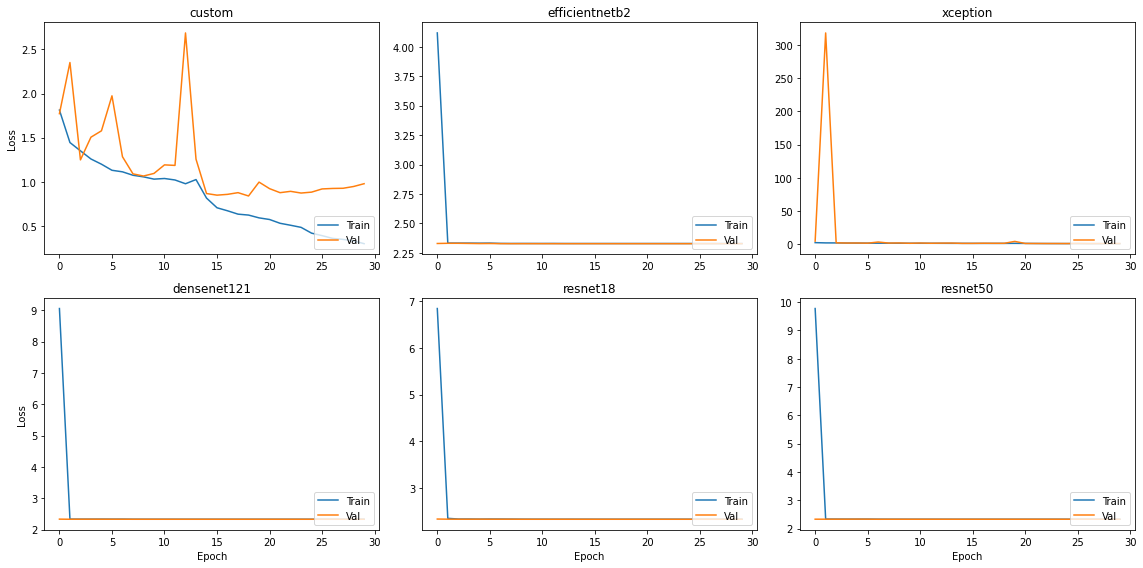

In [43]:
create_loss_plots(results_hists_dict)

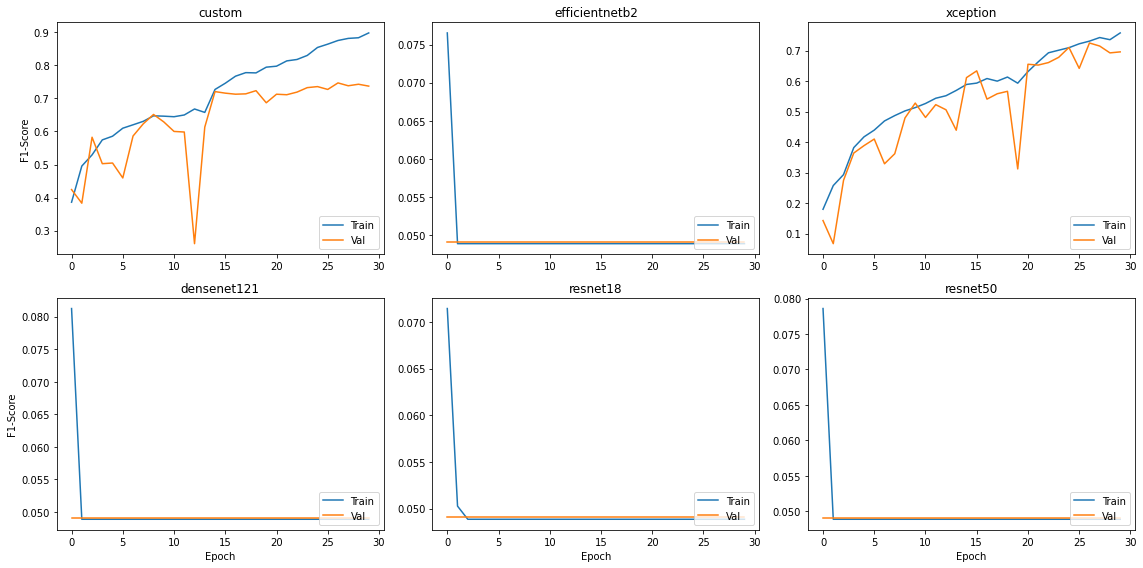

In [44]:
create_f1_plots(results_hists_dict)

In [45]:
df_results = (pd.DataFrame.
              from_dict(results_dict, orient="index", columns=["F1-Score"])
              .sort_values(by=["F1-Score"], ascending=False)
             )
df_results

F1-Score
custom          0.746826
xception        0.725033
efficientnetb2  0.049078
densenet121     0.049078
resnet18        0.049078
resnet50        0.049078

Okay. Seems like only the custom version and the Xception CNN worked out well. The others didn't even learn something. So here it could be interesting to increase the learning rate for example or to try to remove regularization by removing dropout, ...
But for now, I continue with the first two architectures. And for this I know want to train both again but this time with selected augmentations. This shall then finally deliver the final architecture to continue with.

## Add Augmentations
Now it's time to add some augmentations to further boost model performance. I checked different augmentations in the notebook "Check_Augmentations". I applied them on the image and checked whether the output makes sense or not. I don't want to always apply all augmentations. For this purpose, I only apply each augmentation with a certain probability, such that approximately 10% of the images are not augmented.

In [39]:
def apply_augmentation(input_image):
    input_image = np.expand_dims(input_image, axis=0)
    aug_list = [
                iaa.Fliplr(1.0),
                [iaa.Multiply((0.5, 1.5)), iaa.Add((-60, 60))],
                iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
                iaa.GaussianBlur(sigma=(0.5, 1.0)),
                iaa.Affine(scale=(0.5, 1.2)),
                iaa.Rotate((-45, 45)),
                iaa.ElasticTransformation(alpha=(50.0, 300.0), sigma=25.0),
              ]                
    for idx, aug in enumerate(aug_list):
        # only apply augmentation such that in total 10% of the images are not augmented
        # P_single_aug = 1 - exp((1/N) * ln(P_not_aug)) ~ 0.28
        rand_nr = np.random.rand()
        threshold = 0.28
        if isinstance(aug, list):
            rand_aug = np.random.randint(0, 2)
            input_image = np.clip(aug[rand_aug](images=input_image), 0., 255.) if rand_nr <= threshold else input_image
        else:
            input_image = np.clip(aug(images=input_image), 0., 255.) if rand_nr <= threshold else input_image

    return np.squeeze(input_image, axis=0)

In [63]:
encoder_list = ["custom", "xception"]
target_size = (256, 256)
num_epochs = 50
batch_size = 16
results_dict_augs = dict()
results_hists_dict_augs = dict()
img_height, img_width = target_size
color_mode = "rgb"
img_depth = 3

datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., preprocessing_function=apply_augmentation)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_train = datagen_training.flow_from_dataframe(df_train, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)

datagen_val = datagen_valid.flow_from_dataframe(df_val, 
                                                 directory="dataset", 
                                                 x_col="filepath",
                                                 y_col="label",
                                                 target_size=target_size,
                                                 color_mode=color_mode,
                                                 class_mode="categorical",
                                                 batch_size=batch_size,
                                                 seed=42)

# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

for encoder in encoder_list:
    print(f"Start training {encoder}...")
    
            
    model = factory.create_and_return_keras_model(encoder, 
                                                  num_classes=NUM_CLASSES, 
                                                  input_shape=(img_height, img_width, img_depth),
                                                  activation_func="softmax",
                                                  transfer_learning=True)

    hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                    num_epochs=num_epochs, callbacks=[reduce_lr])

    # get the maximum validation f1-score and validation accuracy and store them
    results_dict_augs[encoder] = np.max(hist_dict.history["val_f1_score"])

    # save also the history in order to make some nice visualizations
    results_hists_dict_augs[encoder] = hist_dict.history

Found 4391 validated image filenames belonging to 11 classes.
Found 1098 validated image filenames belonging to 11 classes.
Start training custom...
Epoch 1/50
275/275 [==============================] - 84s 303ms/step - loss: 1.9874 - accuracy: 0.3482 - f1_score: 0.3283 - val_loss: 1.9400 - val_accuracy: 0.3616 - val_f1_score: 0.3222
Epoch 2/50
275/275 [==============================] - 80s 291ms/step - loss: 1.6492 - accuracy: 0.4391 - f1_score: 0.4113 - val_loss: 7.0262 - val_accuracy: 0.1093 - val_f1_score: 0.0852
Epoch 3/50
275/275 [==============================] - 81s 294ms/step - loss: 1.5472 - accuracy: 0.4844 - f1_score: 0.4653 - val_loss: 1.3996 - val_accuracy: 0.5328 - val_f1_score: 0.5094
Epoch 4/50
275/275 [==============================] - 82s 297ms/step - loss: 1.4979 - accuracy: 0.4905 - f1_score: 0.4766 - val_loss: 2.0336 - val_accuracy: 0.3707 - val_f1_score: 0.3328
Epoch 5/50
275/275 [==============================] - 80s 292ms/step - loss: 1.4271 - accuracy: 0.5097 

275/275 [==============================] - 84s 304ms/step - loss: 0.6847 - accuracy: 0.7622 - f1_score: 0.7616 - val_loss: 0.8486 - val_accuracy: 0.7432 - val_f1_score: 0.7399
Epoch 44/50
275/275 [==============================] - 86s 311ms/step - loss: 0.6688 - accuracy: 0.7629 - f1_score: 0.7624 - val_loss: 0.8367 - val_accuracy: 0.7295 - val_f1_score: 0.7256
Epoch 45/50
275/275 [==============================] - 85s 308ms/step - loss: 0.6655 - accuracy: 0.7693 - f1_score: 0.7681 - val_loss: 0.8587 - val_accuracy: 0.7341 - val_f1_score: 0.7309
Epoch 46/50
275/275 [==============================] - 86s 314ms/step - loss: 0.6400 - accuracy: 0.7809 - f1_score: 0.7802 - val_loss: 0.8344 - val_accuracy: 0.7332 - val_f1_score: 0.7328
Epoch 47/50
275/275 [==============================] - 86s 314ms/step - loss: 0.6423 - accuracy: 0.7741 - f1_score: 0.7736 - val_loss: 0.8367 - val_accuracy: 0.7386 - val_f1_score: 0.7355
Epoch 48/50
275/275 [==============================] - 87s 315ms/step - 

Epoch 36/50
275/275 [==============================] - 91s 329ms/step - loss: 1.1416 - accuracy: 0.5980 - f1_score: 0.5836 - val_loss: 1.0485 - val_accuracy: 0.6457 - val_f1_score: 0.6309
Epoch 37/50
275/275 [==============================] - 89s 322ms/step - loss: 1.1499 - accuracy: 0.6085 - f1_score: 0.5955 - val_loss: 1.0275 - val_accuracy: 0.6603 - val_f1_score: 0.6458
Epoch 38/50
275/275 [==============================] - 90s 328ms/step - loss: 1.1063 - accuracy: 0.6147 - f1_score: 0.5991 - val_loss: 1.0104 - val_accuracy: 0.6667 - val_f1_score: 0.6545
Epoch 39/50
275/275 [==============================] - 90s 328ms/step - loss: 1.1028 - accuracy: 0.6242 - f1_score: 0.6126 - val_loss: 1.0342 - val_accuracy: 0.6630 - val_f1_score: 0.6473
Epoch 40/50
275/275 [==============================] - 90s 325ms/step - loss: 1.0878 - accuracy: 0.6233 - f1_score: 0.6125 - val_loss: 0.9914 - val_accuracy: 0.6740 - val_f1_score: 0.6562
Epoch 41/50
275/275 [==============================] - 92s 3

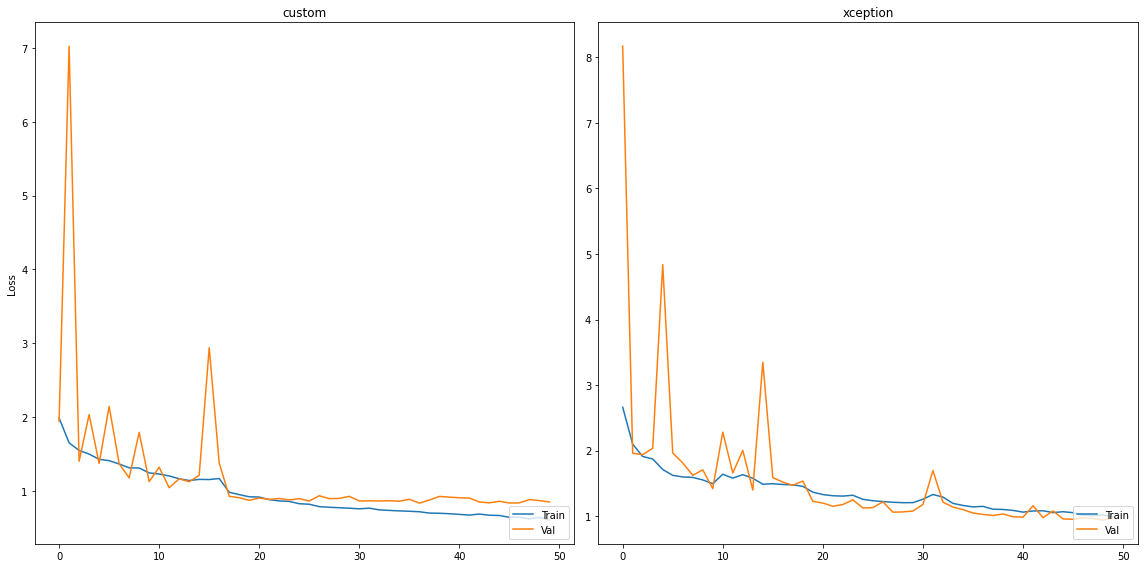

In [64]:
create_loss_plots(results_hists_dict_augs, figpath=r"figures\augmentation_loss.pdf",
                  num_rows=1, num_cols=2)

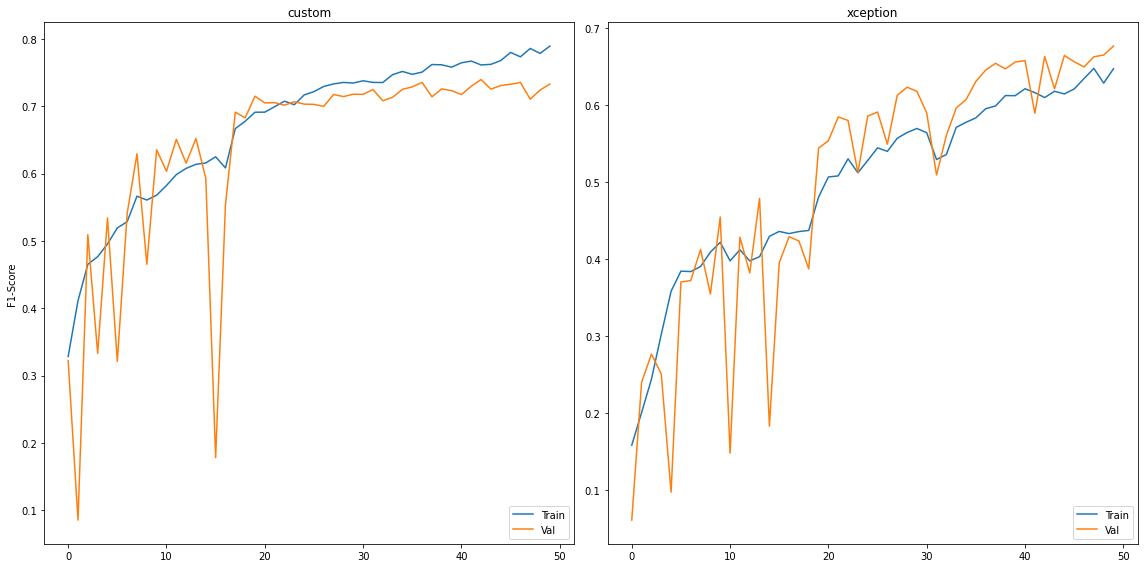

In [65]:
create_f1_plots(results_hists_dict_augs, figpath=r"figures\augmentation_f1_score.pdf",
                num_rows=1, num_cols=2)

In [66]:
df_results = (pd.DataFrame.
              from_dict(results_dict_augs, orient="index", columns=["F1-Score"])
              .sort_values(by=["F1-Score"], ascending=False)
             )
df_results

F1-Score
custom    0.739899
xception  0.676895

Okay well. Seems like the custom version really works best. The augmentations didn't really boost the validation performance, but they led to less overfitting of the custom CNN and therefore lead to a more stable and more generalized CNN architecture. <br> <br>
Let's now try out different imbalance strategies and compare them to the imbalanced model to decide which strategy works best.

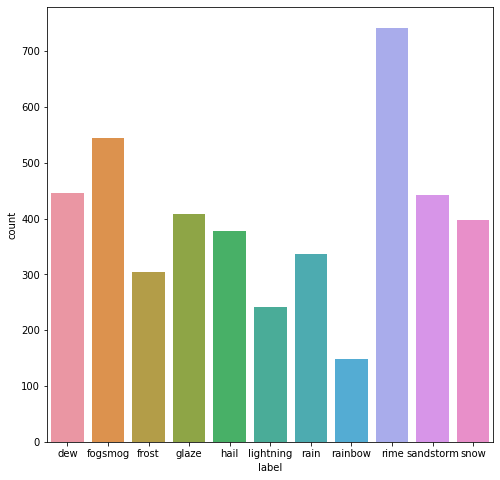

In [71]:
# quick view into training set distribution again
sns.countplot(data=df_train, x="label", order=sorted(sorted(set(df_train["label"]))));

Options to try out:
1. Oversampling: Oversample each class to match the number of samples of the majority class (here: rime). 
2. Undersampling: Undersample each class to match the number of samples of the minority class (here: rainbow).
3. Undersampling with re-sampling: Same as undersampling, but re-sample during training to reduce influence of lost information.

In [40]:
def oversample_dataframe(df_train):
    '''
    This function oversamples the input dataframe to have as many samples per class as the majority class.
    
    Args:
        df_train (pandas DataFrame): The training dataframe that shall be oversampled
    
    Returns:
        final_dataframe (pandas DataFrame): The oversampled dataframe
    '''
    # create copy of dataframe
    df_copy = df_train.copy()
    
    # get list of class_names
    class_names = set(df_copy["label"])
    
    # find majortiy class count
    count_majority = max(df_copy["label"].value_counts().values)
    
    # loop over all classes and oversample until count_majority is reached
    balanced_columns_list = list()
    for label in class_names:
        # create a smaller dataframe only containing the rows with images of the current class
        df_class_current = df_copy[df_copy["label"] == label]
        
        # get the number of samples within that class
        count_class_current = df_class_current.shape[0]
        
        # copy samples from current class until as many samples as in majority class are reached and store them in a dataframe
        df_oversampled = df_class_current.sample(count_majority - count_class_current, replace=True)
        
        # add new oversampled data to initial data and add to list of new dataframe columns
        balanced_columns_list.append(pd.concat([df_class_current, df_oversampled]))
    
    # concatenate all dataframes togehter to get the final one
    final_dataframe = pd.concat(balanced_columns_list)
    
    return final_dataframe

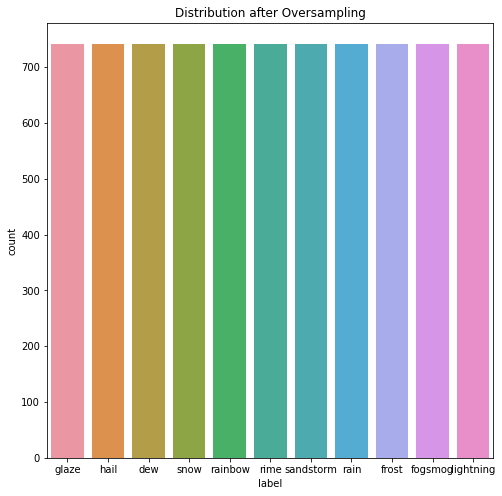

In [41]:
# check if oversampling worked
df_train_oversampled = oversample_dataframe(df_train)
sns.countplot(data=df_train_oversampled, x="label")
plt.title("Distribution after Oversampling")
plt.show()

In [42]:
def undersample_dataframe(df_train, random_seed=42):
    '''
    This function undersamples the input dataframe to have as many samples per class as the minority class. 
    It takes a random_seed as input to allow undersampling with different samples drawn after repeated execution 
    (this is required for undersampling with re-sampling).
    
    Args:
        df_train (pandas DataFrame): The training dataframe that shall be undersampled
        random_seed (integer): Seed used for randomly sampling from the given data
    
    Returns:
        final_dataframe (pandas DataFrame): The undersampled dataframe
    '''
    # create copy of dataframe
    df_copy = df_train.copy()
    
    # get list of class_names
    class_names = set(df_copy["label"])
    
    # find majortiy class count
    count_minority = min(df_copy["label"].value_counts().values)
    
    # loop over all classes and oversample until count_majority is reached
    balanced_columns_list = list()
    for label in class_names:
        # create a smaller dataframe only containing the rows with images of the current class
        df_class_current = df_copy[df_copy["label"] == label]
        
        # get the number of samples within that class
        count_class_current = df_class_current.shape[0]
        
        # copy samples from current class until as many samples as in majority class are reached and store them in a dataframe
        df_undersampled = df_class_current.sample(count_minority, replace=False, random_state=random_seed)
        
        # add new oversampled data to initial data and add to list of new dataframe columns
        balanced_columns_list.append(df_undersampled)
    
    # concatenate all dataframes togehter to get the final one
    final_dataframe = pd.concat(balanced_columns_list)
    
    return final_dataframe

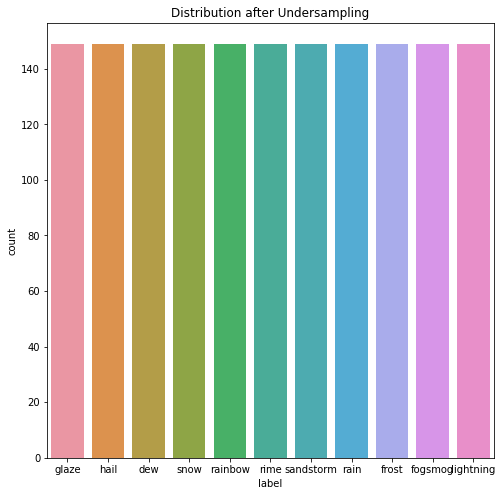

In [43]:
# check if undersampling worked
df_train_undersampled = undersample_dataframe(df_train)
sns.countplot(data=df_train_undersampled, x="label")
plt.title("Distribution after Undersampling")
plt.show()

Let's quickly check that the samples are different for different seeds and equal for equal seeds.

In [44]:
def compare_lists(list1, list2):
    return list1 == list2

In [45]:
test1 = undersample_dataframe(df_train, random_seed=10)["filepath"].to_list()
test2 = undersample_dataframe(df_train, random_seed=100)["filepath"].to_list()

assert compare_lists(test1, test2) == False, "The lists are identical, but should be different"

In [46]:
test3 = undersample_dataframe(df_train, random_seed=10)["filepath"].to_list()
test4 = undersample_dataframe(df_train, random_seed=10)["filepath"].to_list()

assert compare_lists(test3, test4) == True, "The lists are different, but should be identical"

Perfect. So the undersampling with re-sampling returns different datasets. This is awesome! Let's now train a model for each of these methods.

In [162]:
encoder = "custom"
target_size = (256, 256)
num_epochs = 60
batch_size = 16
results_dict_imbalance = dict()
results_hists_dict_imbalance = dict()
img_height, img_width = target_size
color_mode = "rgb"
img_depth = 3

datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., preprocessing_function=apply_augmentation)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_val = datagen_valid.flow_from_dataframe(df_val, 
                                                 directory="dataset", 
                                                 x_col="filepath",
                                                 y_col="label",
                                                 target_size=target_size,
                                                 color_mode=color_mode,
                                                 class_mode="categorical",
                                                 batch_size=batch_size,
                                                 seed=42)

Found 1098 validated image filenames belonging to 11 classes.


### Oversampling

In [163]:
strategy = "oversampling"
df_train_oversampled = oversample_dataframe(df_train)
datagen_train = datagen_training.flow_from_dataframe(df_train_oversampled, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)



# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                num_epochs=num_epochs, callbacks=[reduce_lr])

# get the maximum validation f1-score and validation accuracy and store them
results_dict_imbalance[strategy] = np.max(hist_dict.history["val_f1_score"])

# save also the history in order to make some nice visualizations
results_hists_dict_imbalance[strategy] = hist_dict.history

Found 8162 validated image filenames belonging to 11 classes.
Epoch 1/60
511/511 [==============================] - 166s 324ms/step - loss: 1.8146 - accuracy: 0.3815 - f1_score: 0.3804 - val_loss: 3.1766 - val_accuracy: 0.2514 - val_f1_score: 0.1830
Epoch 2/60
511/511 [==============================] - 162s 316ms/step - loss: 1.4761 - accuracy: 0.4909 - f1_score: 0.4877 - val_loss: 1.6662 - val_accuracy: 0.4435 - val_f1_score: 0.4040
Epoch 3/60
511/511 [==============================] - 164s 321ms/step - loss: 1.3641 - accuracy: 0.5301 - f1_score: 0.5280 - val_loss: 1.4672 - val_accuracy: 0.5055 - val_f1_score: 0.5042
Epoch 4/60
511/511 [==============================] - 156s 305ms/step - loss: 1.3198 - accuracy: 0.5515 - f1_score: 0.5503 - val_loss: 1.4744 - val_accuracy: 0.5410 - val_f1_score: 0.5254
Epoch 5/60
511/511 [==============================] - 157s 307ms/step - loss: 1.2725 - accuracy: 0.5744 - f1_score: 0.5735 - val_loss: 1.3623 - val_accuracy: 0.5610 - val_f1_score: 0.569

## Undersampling

In [164]:
strategy = "undersampling"
df_train_undersampled = undersample_dataframe(df_train)
datagen_train = datagen_training.flow_from_dataframe(df_train_undersampled, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)



# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                num_epochs=num_epochs, callbacks=[reduce_lr])

# get the maximum validation f1-score and validation accuracy and store them
results_dict_imbalance[strategy] = np.max(hist_dict.history["val_f1_score"])

# save also the history in order to make some nice visualizations
results_hists_dict_imbalance[strategy] = hist_dict.history

Found 1639 validated image filenames belonging to 11 classes.
Epoch 1/60
103/103 [==============================] - 35s 337ms/step - loss: 2.2634 - accuracy: 0.2611 - f1_score: 0.2569 - val_loss: 4.6009 - val_accuracy: 0.1676 - val_f1_score: 0.1090
Epoch 2/60
103/103 [==============================] - 35s 336ms/step - loss: 1.9046 - accuracy: 0.3386 - f1_score: 0.3303 - val_loss: 1.7808 - val_accuracy: 0.3588 - val_f1_score: 0.3500
Epoch 3/60
103/103 [==============================] - 34s 331ms/step - loss: 1.7382 - accuracy: 0.3777 - f1_score: 0.3725 - val_loss: 1.7532 - val_accuracy: 0.3643 - val_f1_score: 0.3553
Epoch 4/60
103/103 [==============================] - 34s 335ms/step - loss: 1.6578 - accuracy: 0.4082 - f1_score: 0.4056 - val_loss: 1.7368 - val_accuracy: 0.3980 - val_f1_score: 0.3922
Epoch 5/60
103/103 [==============================] - 34s 329ms/step - loss: 1.6278 - accuracy: 0.4362 - f1_score: 0.4347 - val_loss: 1.6227 - val_accuracy: 0.4408 - val_f1_score: 0.4019
Epo

### Undersampling with Re-Sampling
Here, I like to re-sample after every fifth epoch to introduce new samples.

In [165]:
def convert_history_dicts_to_hist(history_dicts):
    '''
    This function takes a list of history dicts returned from keras.fit() function and converts them to one global history.
    This is usefull in case re-sampling is applied and one global history should be stored.

    Args:
        history_dicts (list of dictionaries): List of dictioniaries containing the results of keras.fit() return

    Returns:
        new_history (dict): New history with concatenated results        
    '''
    new_history = history_dicts[0].history.copy()
    for idx in range(1, len(history_dicts)):
        for key in history_dicts[idx].history.keys():
            new_history[key] += history_dicts[idx].history[key]      

    return new_history   

In [166]:
strategy = "undersampling_with_resampling"

# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)
        
model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)
history_dicts_list = list()
for epoch in range(1, num_epochs+1, 5):
    print(f"Epoch {epoch}/{num_epochs}")
    random_seed = np.random.randint(0, 1000)
    df_train_undersampled = undersample_dataframe(df_train)
    datagen_train = datagen_training.flow_from_dataframe(df_train_undersampled, 
                                                         directory="dataset", 
                                                         x_col="filepath",
                                                         y_col="label",
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode="categorical",
                                                         batch_size=batch_size,
                                                         seed=42)


    hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                    num_epochs=5, callbacks=[reduce_lr])
    history_dicts_list.append(hist_dict)

# save also the history in order to make some nice visualizations
results_hists_dict_imbalance[strategy] = convert_history_dicts_to_hist(history_dicts_list)

# get the maximum validation f1-score and validation accuracy and store them
results_dict_imbalance[strategy] = np.max(results_hists_dict_imbalance[strategy]["val_f1_score"])

Epoch 1/60
Found 1639 validated image filenames belonging to 11 classes.
Epoch 1/5
103/103 [==============================] - 36s 341ms/step - loss: 2.4077 - accuracy: 0.2221 - f1_score: 0.2223 - val_loss: 3.4994 - val_accuracy: 0.1193 - val_f1_score: 0.0484
Epoch 2/5
103/103 [==============================] - 35s 341ms/step - loss: 1.8646 - accuracy: 0.3594 - f1_score: 0.3525 - val_loss: 4.4527 - val_accuracy: 0.1357 - val_f1_score: 0.0862
Epoch 3/5
103/103 [==============================] - 34s 332ms/step - loss: 1.8058 - accuracy: 0.3594 - f1_score: 0.3541 - val_loss: 2.2913 - val_accuracy: 0.2559 - val_f1_score: 0.2373
Epoch 4/5
103/103 [==============================] - 34s 333ms/step - loss: 1.7425 - accuracy: 0.3972 - f1_score: 0.3904 - val_loss: 2.4073 - val_accuracy: 0.3852 - val_f1_score: 0.3691
Epoch 5/5
103/103 [==============================] - 35s 342ms/step - loss: 1.6447 - accuracy: 0.4228 - f1_score: 0.4182 - val_loss: 1.8900 - val_accuracy: 0.3898 - val_f1_score: 0.35

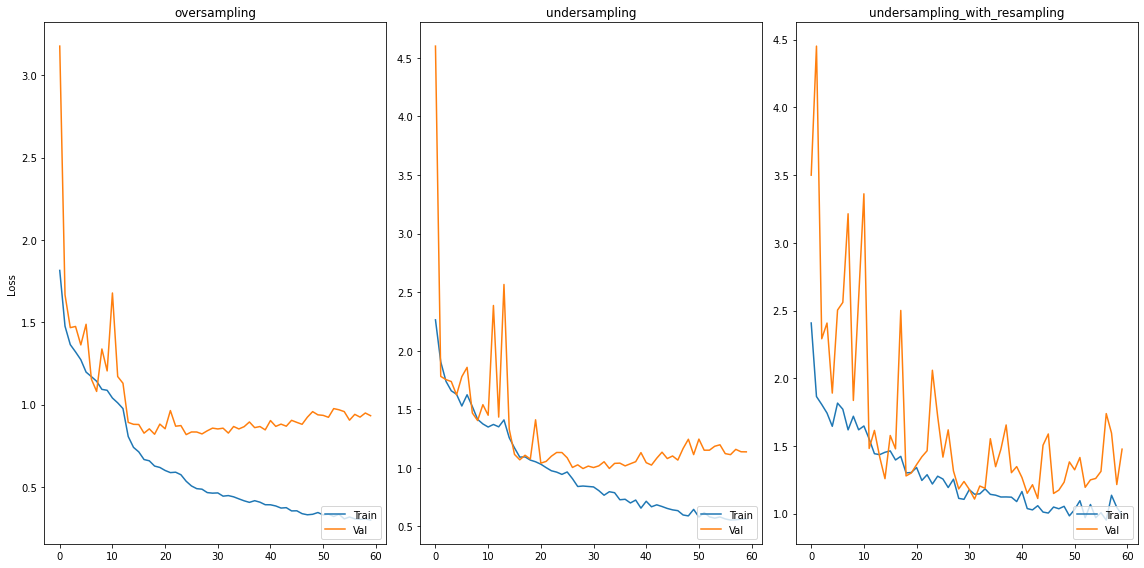

In [167]:
create_loss_plots(results_hists_dict_imbalance, figpath=r"figures\imbalance_loss.pdf",
                  num_rows=1, num_cols=3)

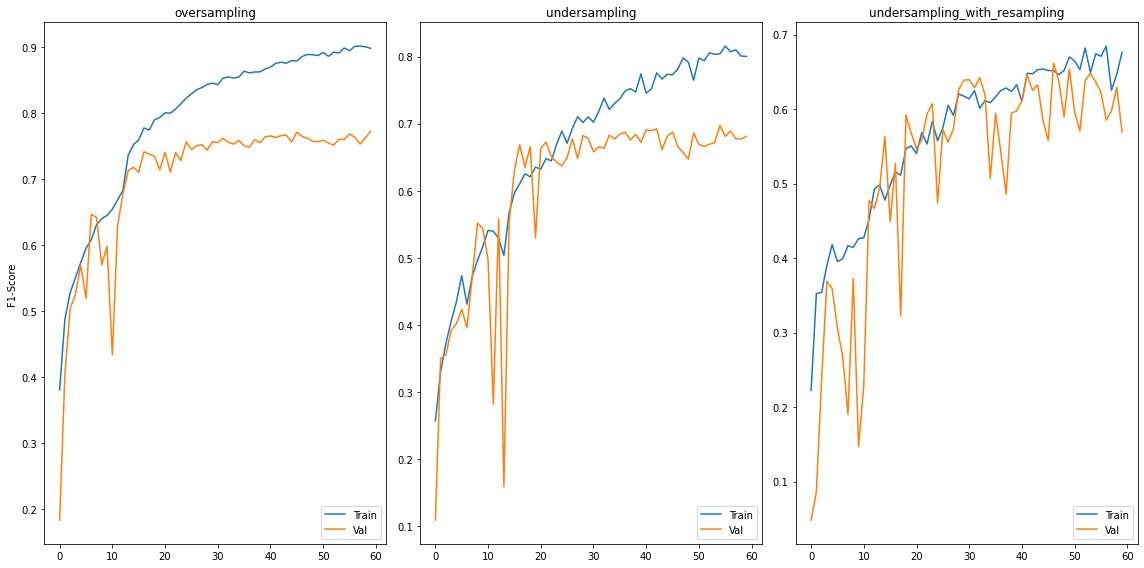

In [168]:
create_f1_plots(results_hists_dict_imbalance, figpath=r"figures\imbalance_f1_score.pdf",
                num_rows=1, num_cols=3)

In [169]:
df_results = (pd.DataFrame.
              from_dict(results_dict_imbalance, orient="index", columns=["F1-Score"])
              .sort_values(by=["F1-Score"], ascending=False)
             )
df_results

F1-Score
oversampling                   0.772617
undersampling                  0.697553
undersampling_with_resampling  0.661971

Oversampling achieved the highest F1-Score, but the training curves indicate a clear trend to overfitting. Undersampling has the same problem. Undersampling with re-sampling also didn't really improve the F1-Scores, but it didn't run into overfitting. <br> <br> 
Let's quickly try to run the Xception on the oversampling and undersampling with re-sampling, because the seem to be more promising and the Xception network could be less prone to overfitting. Let's train them for more epochs then for the custom model.

In [170]:
encoder = "xception"
target_size = (256, 256)

num_epochs = 70
batch_size = 16
results_dict_imbalance = dict()
results_hists_dict_imbalance = dict()
img_height, img_width = target_size
color_mode = "rgb"
img_depth = 3

datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., preprocessing_function=apply_augmentation)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_val = datagen_valid.flow_from_dataframe(df_val, 
                                                 directory="dataset", 
                                                 x_col="filepath",
                                                 y_col="label",
                                                 target_size=target_size,
                                                 color_mode=color_mode,
                                                 class_mode="categorical",
                                                 batch_size=batch_size,
                                                 seed=42)

Found 1098 validated image filenames belonging to 11 classes.


In [172]:
strategy = "oversampling"
df_train_oversampled = oversample_dataframe(df_train)
datagen_train = datagen_training.flow_from_dataframe(df_train_oversampled, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)



# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                num_epochs=num_epochs, callbacks=[reduce_lr])

# get the maximum validation f1-score and validation accuracy and store them
results_dict_imbalance[strategy] = np.max(hist_dict.history["val_f1_score"])

# save also the history in order to make some nice visualizations
results_hists_dict_imbalance[strategy] = hist_dict.history

Found 8162 validated image filenames belonging to 11 classes.
Epoch 1/70
511/511 [==============================] - 194s 369ms/step - loss: 2.7663 - accuracy: 0.1356 - f1_score: 0.1283 - val_loss: 2.4183 - val_accuracy: 0.0902 - val_f1_score: 0.0149
Epoch 2/70
511/511 [==============================] - 197s 384ms/step - loss: 2.2845 - accuracy: 0.1576 - f1_score: 0.1375 - val_loss: 2.0518 - val_accuracy: 0.2477 - val_f1_score: 0.1587
Epoch 3/70
511/511 [==============================] - 191s 373ms/step - loss: 1.9486 - accuracy: 0.2531 - f1_score: 0.2485 - val_loss: 1.7116 - val_accuracy: 0.3588 - val_f1_score: 0.3028
Epoch 4/70
511/511 [==============================] - 196s 382ms/step - loss: 1.7671 - accuracy: 0.3247 - f1_score: 0.3129 - val_loss: 2.3305 - val_accuracy: 0.3005 - val_f1_score: 0.2552
Epoch 5/70
511/511 [==============================] - 170s 332ms/step - loss: 1.6323 - accuracy: 0.3863 - f1_score: 0.3768 - val_loss: 1.5539 - val_accuracy: 0.4408 - val_f1_score: 0.409

In [173]:
strategy = "undersampling_with_resampling"

# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=0.001, min_delta=0.001)
        
model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)
history_dicts_list = list()
for epoch in range(1, num_epochs+1, 5):
    print(f"Epoch {epoch}/{num_epochs}")
    random_seed = np.random.randint(0, 1000)
    df_train_undersampled = undersample_dataframe(df_train)
    datagen_train = datagen_training.flow_from_dataframe(df_train_undersampled, 
                                                         directory="dataset", 
                                                         x_col="filepath",
                                                         y_col="label",
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode="categorical",
                                                         batch_size=batch_size,
                                                         seed=42)


    hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=1e-2, 
                                    num_epochs=5, callbacks=[reduce_lr])
    history_dicts_list.append(hist_dict)

# save also the history in order to make some nice visualizations
results_hists_dict_imbalance[strategy] = convert_history_dicts_to_hist(history_dicts_list)

# get the maximum validation f1-score and validation accuracy and store them
results_dict_imbalance[strategy] = np.max(results_hists_dict_imbalance[strategy]["val_f1_score"])

Epoch 1/70
Found 1639 validated image filenames belonging to 11 classes.
Epoch 1/5
103/103 [==============================] - 46s 409ms/step - loss: 3.1599 - accuracy: 0.0757 - f1_score: 0.0634 - val_loss: 2.5737 - val_accuracy: 0.0938 - val_f1_score: 0.0227
Epoch 2/5
103/103 [==============================] - 39s 375ms/step - loss: 2.4070 - accuracy: 0.0860 - f1_score: 0.0434 - val_loss: 2.3879 - val_accuracy: 0.0865 - val_f1_score: 0.0138
Epoch 3/5
103/103 [==============================] - 39s 375ms/step - loss: 2.3968 - accuracy: 0.1007 - f1_score: 0.0634 - val_loss: 2.3797 - val_accuracy: 0.1257 - val_f1_score: 0.0512
Epoch 4/5
103/103 [==============================] - 39s 378ms/step - loss: 2.3636 - accuracy: 0.0982 - f1_score: 0.0698 - val_loss: 2.2950 - val_accuracy: 0.1512 - val_f1_score: 0.0616
Epoch 5/5
103/103 [==============================] - 39s 378ms/step - loss: 2.3639 - accuracy: 0.1086 - f1_score: 0.0838 - val_loss: 6.3443 - val_accuracy: 0.0920 - val_f1_score: 0.04

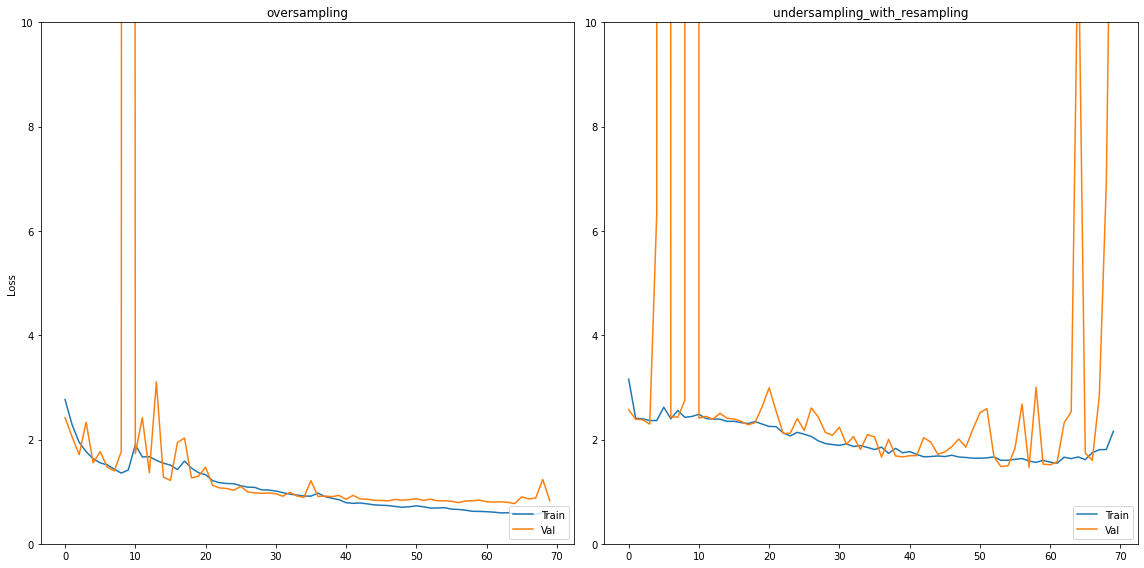

In [180]:
create_loss_plots(results_hists_dict_imbalance, figpath=r"figures\imbalance_loss_xception.pdf",
                  num_rows=1, num_cols=2)

Okay that does not look good thanks to some outliers. Let's reduce the y-range to be able to better see the difference between training and validation curves to search for overfitting.

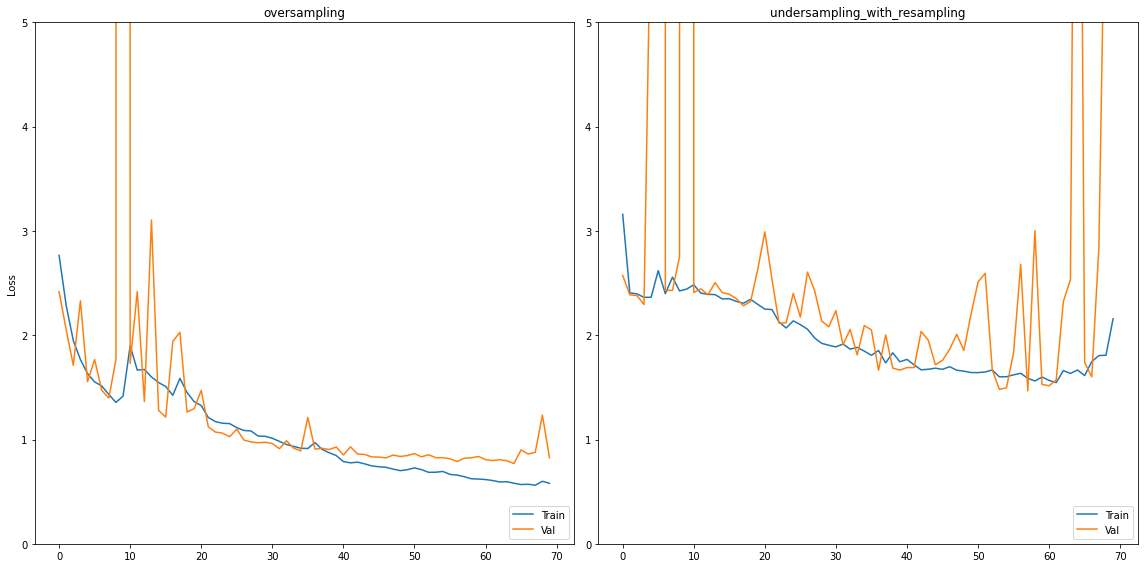

In [181]:
create_loss_plots(results_hists_dict_imbalance, figpath=r"figures\imbalance_loss_xception.pdf",
                  num_rows=1, num_cols=2, ylim=(0, 5))

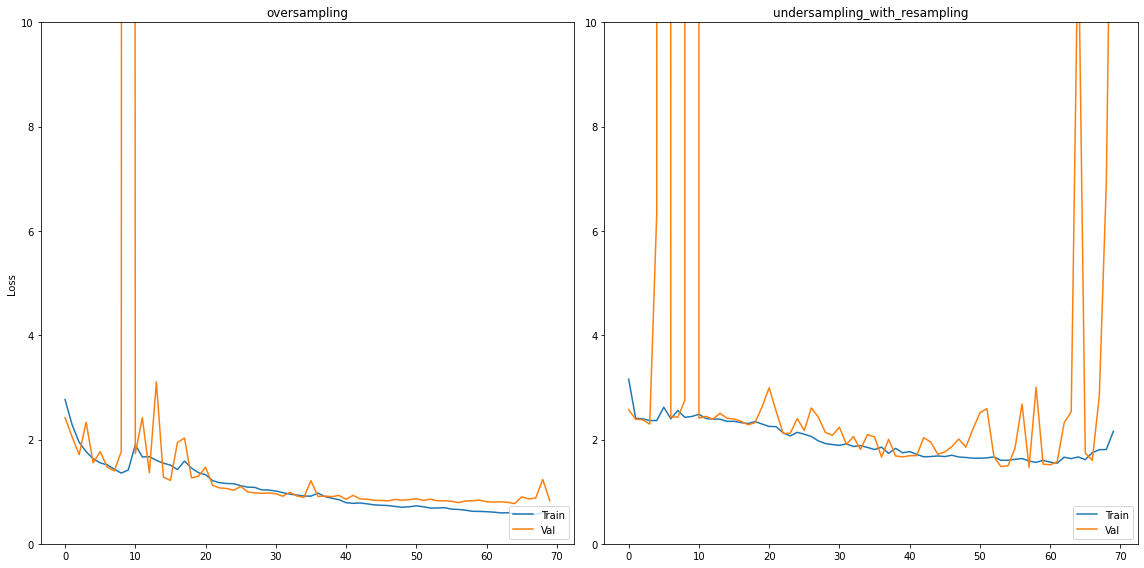

In [179]:
create_loss_plots(results_hists_dict_imbalance, figpath=r"figures\imbalance_loss_xception.pdf",
                  num_rows=1, num_cols=2)

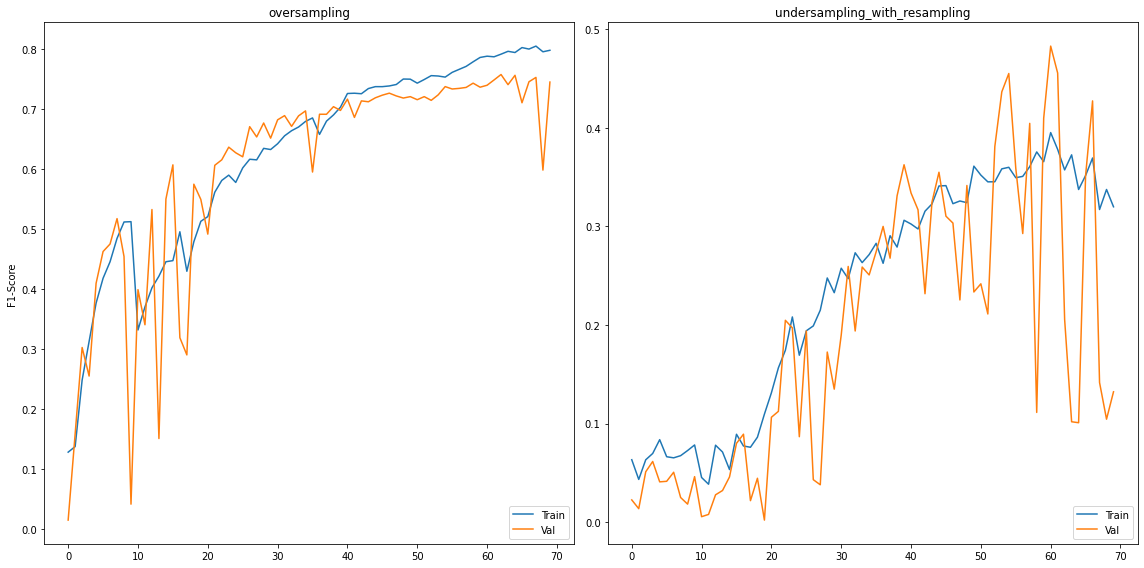

In [175]:
create_f1_plots(results_hists_dict_imbalance, figpath=r"figures\imbalance_f1_score_xception.pdf",
                num_rows=1, num_cols=2)

In [176]:
df_results = (pd.DataFrame.
              from_dict(results_dict_imbalance, orient="index", columns=["F1-Score"])
              .sort_values(by=["F1-Score"], ascending=False)
             )
df_results

F1-Score
oversampling                   0.758224
undersampling_with_resampling  0.482910

Okay. It's now clear that the Xception network is less susceptible to overfitting with oversampling delivering good results. Let's use the Xception network as the final model, because when in future more data would be available, then I think the Xception network could better generalize as the small customly created model. In addition, it has the best validation f1-score when leaving out the custom oversampling results, because there the model is clearly overfitted very quickly.

# Training of Final Model
I like to train the final model for a certain fixed number of epochs, where always the best model according to the validation f1-score is stored. Another option is to use early stopping. But I'm personal not a fan of early stopping, because it could also stop too early when the amount of epochs without improvement is set too low.

In [48]:
encoder = "xception"
target_size = (256, 256)

num_epochs = 100
batch_size = 16
results_dict_imbalance = dict()
results_hists_dict_imbalance = dict()
img_height, img_width = target_size
color_mode = "rgb"
img_depth = 3

datagen_training = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255., preprocessing_function=apply_augmentation)
datagen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

datagen_val = datagen_valid.flow_from_dataframe(df_val, 
                                                 directory="dataset", 
                                                 x_col="filepath",
                                                 y_col="label",
                                                 target_size=target_size,
                                                 color_mode=color_mode,
                                                 class_mode="categorical",
                                                 batch_size=batch_size,
                                                 seed=42)

df_train_oversampled = oversample_dataframe(df_train)
datagen_train = datagen_training.flow_from_dataframe(df_train_oversampled, 
                                                     directory="dataset", 
                                                     x_col="filepath",
                                                     y_col="label",
                                                     target_size=target_size,
                                                     color_mode=color_mode,
                                                     class_mode="categorical",
                                                     batch_size=batch_size,
                                                     seed=42)



# Define the LR Plateau Optimizer
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                                                 patience=5, min_lr=1e-5, min_delta=0.001)

# create the callback for storing the best model
path_to_store = r"model\best_model_{epoch:02d}_{val_f1_score:.3f}"
save_bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_to_store, 
                                                             save_weights_only=False, 
                                                             verbose=1,
                                                             monitor="val_f1_score", 
                                                             save_best_only=True, 
                                                             mode="max")

model = factory.create_and_return_keras_model(encoder, 
                                              num_classes=NUM_CLASSES, 
                                              input_shape=(img_height, img_width, img_depth),
                                              activation_func="softmax",
                                              transfer_learning=True)

hist_dict = end_to_end_training(model, datagen_train, datagen_val, lr_val=5e-3, 
                                num_epochs=num_epochs, callbacks=[reduce_lr, save_bestmodel_callback])

Found 1098 validated image filenames belonging to 11 classes.
Found 8162 validated image filenames belonging to 11 classes.
Epoch 1/100
511/511 [==============================] - 186s 355ms/step - loss: 1.9332 - accuracy: 0.3246 - f1_score: 0.3188 - val_loss: 3.1567 - val_accuracy: 0.2514 - val_f1_score: 0.1970

Epoch 00001: val_f1_score improved from -inf to 0.19698, saving model to model\best_model_01_0.197


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_01_0.197\assets
Epoch 2/100
511/511 [==============================] - 165s 323ms/step - loss: 1.4397 - accuracy: 0.4848 - f1_score: 0.4780 - val_loss: 4.7966 - val_accuracy: 0.4326 - val_f1_score: 0.3923

Epoch 00002: val_f1_score improved from 0.19698 to 0.39230, saving model to model\best_model_02_0.392


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_02_0.392\assets
Epoch 3/100
511/511 [==============================] - 171s 335ms/step - loss: 1.3835 - accuracy: 0.5159 - f1_score: 0.5105 - val_loss: 1.3873 - val_accuracy: 0.5355 - val_f1_score: 0.5404

Epoch 00003: val_f1_score improved from 0.39230 to 0.54041, saving model to model\best_model_03_0.540


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_03_0.540\assets
Epoch 4/100
511/511 [==============================] - 171s 335ms/step - loss: 1.2617 - accuracy: 0.5553 - f1_score: 0.5507 - val_loss: 1.3218 - val_accuracy: 0.6093 - val_f1_score: 0.5997

Epoch 00004: val_f1_score improved from 0.54041 to 0.59973, saving model to model\best_model_04_0.600


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_04_0.600\assets
Epoch 5/100
511/511 [==============================] - 165s 322ms/step - loss: 1.1873 - accuracy: 0.5848 - f1_score: 0.5800 - val_loss: 1.1960 - val_accuracy: 0.5510 - val_f1_score: 0.5283

Epoch 00005: val_f1_score did not improve from 0.59973
Epoch 6/100
511/511 [==============================] - 163s 318ms/step - loss: 1.1319 - accuracy: 0.6087 - f1_score: 0.6048 - val_loss: 4.1380 - val_accuracy: 0.3944 - val_f1_score: 0.3687

Epoch 00006: val_f1_score did not improve from 0.59973
Epoch 7/100
511/511 [==============================] - 162s 317ms/step - loss: 1.0897 - accuracy: 0.6245 - f1_score: 0.6195 - val_loss: 1.5950 - val_accuracy: 0.4863 - val_f1_score: 0.5099

Epoch 00007: val_f1_score did not improve from 0.59973
Epoch 8/100
511/511 [==============================] - 163s 319ms/step - loss: 1.1397 - accuracy: 0.6142 - f1_score: 0.6102 - val_loss: 1.2394 - val_accuracy: 0.6302 - val_f1_score: 0.5993

Epoch 0

C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_10_0.664\assets
Epoch 11/100
511/511 [==============================] - 166s 324ms/step - loss: 0.9310 - accuracy: 0.6846 - f1_score: 0.6835 - val_loss: 1.1601 - val_accuracy: 0.6758 - val_f1_score: 0.6917

Epoch 00011: val_f1_score improved from 0.66355 to 0.69174, saving model to model\best_model_11_0.692


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_11_0.692\assets
Epoch 12/100
511/511 [==============================] - 164s 321ms/step - loss: 0.9881 - accuracy: 0.6670 - f1_score: 0.6646 - val_loss: 1.4666 - val_accuracy: 0.5610 - val_f1_score: 0.5382

Epoch 00012: val_f1_score did not improve from 0.69174
Epoch 13/100
511/511 [==============================] - 163s 318ms/step - loss: 0.8798 - accuracy: 0.7060 - f1_score: 0.7051 - val_loss: 0.9933 - val_accuracy: 0.6794 - val_f1_score: 0.6587

Epoch 00013: val_f1_score did not improve from 0.69174
Epoch 14/100
511/511 [==============================] - 165s 323ms/step - loss: 0.8585 - accuracy: 0.7145 - f1_score: 0.7128 - val_loss: 1.0728 - val_accuracy: 0.6566 - val_f1_score: 0.6328

Epoch 00014: val_f1_score did not improve from 0.69174
Epoch 15/100
511/511 [==============================] - 165s 322ms/step - loss: 0.7988 - accuracy: 0.7355 - f1_score: 0.7352 - val_loss: 0.8635 - val_accuracy: 0.7231 - val_f1_score: 0.7155

Epo

C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_15_0.716\assets
Epoch 16/100
511/511 [==============================] - 163s 318ms/step - loss: 0.7721 - accuracy: 0.7389 - f1_score: 0.7374 - val_loss: 1.2377 - val_accuracy: 0.6257 - val_f1_score: 0.6402

Epoch 00016: val_f1_score did not improve from 0.71552
Epoch 17/100
511/511 [==============================] - 163s 319ms/step - loss: 0.7320 - accuracy: 0.7567 - f1_score: 0.7560 - val_loss: 1.0626 - val_accuracy: 0.7067 - val_f1_score: 0.6985

Epoch 00017: val_f1_score did not improve from 0.71552
Epoch 18/100
511/511 [==============================] - 161s 315ms/step - loss: 0.7364 - accuracy: 0.7532 - f1_score: 0.7531 - val_loss: 1.0720 - val_accuracy: 0.6840 - val_f1_score: 0.6497

Epoch 00018: val_f1_score did not improve from 0.71552
Epoch 19/100
511/511 [==============================] - 164s 320ms/step - loss: 0.6938 - accuracy: 0.7662 - f1_score: 0.7663 - val_loss: 0.8388 - val_accuracy: 0.7468 - val_f1_score: 0.7511

Epo

C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_19_0.751\assets
Epoch 20/100
511/511 [==============================] - 166s 324ms/step - loss: 0.7356 - accuracy: 0.7535 - f1_score: 0.7531 - val_loss: 1.8570 - val_accuracy: 0.5373 - val_f1_score: 0.5553

Epoch 00020: val_f1_score did not improve from 0.75115
Epoch 21/100
511/511 [==============================] - 162s 317ms/step - loss: 0.6646 - accuracy: 0.7722 - f1_score: 0.7727 - val_loss: 1.2918 - val_accuracy: 0.7013 - val_f1_score: 0.6649

Epoch 00021: val_f1_score did not improve from 0.75115
Epoch 22/100
511/511 [==============================] - 164s 320ms/step - loss: 0.6754 - accuracy: 0.7699 - f1_score: 0.7700 - val_loss: 2.8183 - val_accuracy: 0.5182 - val_f1_score: 0.5247

Epoch 00022: val_f1_score did not improve from 0.75115
Epoch 23/100
511/511 [==============================] - 162s 316ms/step - loss: 0.6600 - accuracy: 0.7782 - f1_score: 0.7788 - val_loss: 0.7351 - val_accuracy: 0.7750 - val_f1_score: 0.7669

Epo

C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_23_0.767\assets
Epoch 24/100
511/511 [==============================] - 163s 318ms/step - loss: 0.6184 - accuracy: 0.7927 - f1_score: 0.7921 - val_loss: 0.7792 - val_accuracy: 0.7614 - val_f1_score: 0.7649

Epoch 00024: val_f1_score did not improve from 0.76689
Epoch 25/100
511/511 [==============================] - 163s 319ms/step - loss: 0.6013 - accuracy: 0.7928 - f1_score: 0.7924 - val_loss: 0.7554 - val_accuracy: 0.7587 - val_f1_score: 0.7504

Epoch 00025: val_f1_score did not improve from 0.76689
Epoch 26/100
511/511 [==============================] - 165s 322ms/step - loss: 0.5891 - accuracy: 0.8048 - f1_score: 0.8052 - val_loss: 0.7251 - val_accuracy: 0.7778 - val_f1_score: 0.7806

Epoch 00026: val_f1_score improved from 0.76689 to 0.78055, saving model to model\best_model_26_0.781


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_26_0.781\assets
Epoch 27/100
511/511 [==============================] - 166s 324ms/step - loss: 0.5835 - accuracy: 0.8012 - f1_score: 0.8006 - val_loss: 0.6307 - val_accuracy: 0.7951 - val_f1_score: 0.7996

Epoch 00027: val_f1_score improved from 0.78055 to 0.79962, saving model to model\best_model_27_0.800


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_27_0.800\assets
Epoch 28/100
511/511 [==============================] - 163s 318ms/step - loss: 0.5577 - accuracy: 0.8160 - f1_score: 0.8165 - val_loss: 0.6227 - val_accuracy: 0.7851 - val_f1_score: 0.7814

Epoch 00028: val_f1_score did not improve from 0.79962
Epoch 29/100
511/511 [==============================] - 161s 316ms/step - loss: 0.5607 - accuracy: 0.8165 - f1_score: 0.8165 - val_loss: 0.7368 - val_accuracy: 0.7905 - val_f1_score: 0.7825

Epoch 00029: val_f1_score did not improve from 0.79962
Epoch 30/100
511/511 [==============================] - 162s 317ms/step - loss: 0.5338 - accuracy: 0.8210 - f1_score: 0.8215 - val_loss: 0.7159 - val_accuracy: 0.7659 - val_f1_score: 0.7670

Epoch 00030: val_f1_score did not improve from 0.79962
Epoch 31/100
511/511 [==============================] - 163s 319ms/step - loss: 0.5191 - accuracy: 0.8272 - f1_score: 0.8280 - val_loss: 0.7001 - val_accuracy: 0.8015 - val_f1_score: 0.7991

Epo

C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_34_0.839\assets
Epoch 35/100
511/511 [==============================] - 163s 318ms/step - loss: 0.3464 - accuracy: 0.8827 - f1_score: 0.8830 - val_loss: 0.5168 - val_accuracy: 0.8379 - val_f1_score: 0.8370

Epoch 00035: val_f1_score did not improve from 0.83900
Epoch 36/100
511/511 [==============================] - 164s 321ms/step - loss: 0.3142 - accuracy: 0.8929 - f1_score: 0.8929 - val_loss: 0.5087 - val_accuracy: 0.8561 - val_f1_score: 0.8562

Epoch 00036: val_f1_score improved from 0.83900 to 0.85619, saving model to model\best_model_36_0.856


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_36_0.856\assets
Epoch 37/100
511/511 [==============================] - 163s 319ms/step - loss: 0.3022 - accuracy: 0.9006 - f1_score: 0.9006 - val_loss: 0.5371 - val_accuracy: 0.8443 - val_f1_score: 0.8437

Epoch 00037: val_f1_score did not improve from 0.85619
Epoch 38/100
511/511 [==============================] - 163s 319ms/step - loss: 0.2736 - accuracy: 0.9090 - f1_score: 0.9092 - val_loss: 0.5296 - val_accuracy: 0.8561 - val_f1_score: 0.8577

Epoch 00038: val_f1_score improved from 0.85619 to 0.85772, saving model to model\best_model_38_0.858


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_38_0.858\assets
Epoch 39/100
511/511 [==============================] - 164s 320ms/step - loss: 0.2891 - accuracy: 0.9044 - f1_score: 0.9046 - val_loss: 0.5318 - val_accuracy: 0.8443 - val_f1_score: 0.8450

Epoch 00039: val_f1_score did not improve from 0.85772
Epoch 40/100
511/511 [==============================] - 164s 320ms/step - loss: 0.2742 - accuracy: 0.9077 - f1_score: 0.9078 - val_loss: 0.4881 - val_accuracy: 0.8534 - val_f1_score: 0.8540

Epoch 00040: val_f1_score did not improve from 0.85772
Epoch 41/100
511/511 [==============================] - 164s 321ms/step - loss: 0.2577 - accuracy: 0.9107 - f1_score: 0.9107 - val_loss: 0.5196 - val_accuracy: 0.8579 - val_f1_score: 0.8584

Epoch 00041: val_f1_score improved from 0.85772 to 0.85837, saving model to model\best_model_41_0.858


C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_41_0.858\assets
Epoch 42/100
511/511 [==============================] - 164s 321ms/step - loss: 0.2573 - accuracy: 0.9126 - f1_score: 0.9127 - val_loss: 0.6204 - val_accuracy: 0.8342 - val_f1_score: 0.8351

Epoch 00042: val_f1_score did not improve from 0.85837
Epoch 43/100
511/511 [==============================] - 166s 324ms/step - loss: 0.2497 - accuracy: 0.9188 - f1_score: 0.9188 - val_loss: 0.5580 - val_accuracy: 0.8470 - val_f1_score: 0.8477

Epoch 00043: val_f1_score did not improve from 0.85837
Epoch 44/100
511/511 [==============================] - 166s 324ms/step - loss: 0.2468 - accuracy: 0.9184 - f1_score: 0.9185 - val_loss: 0.5650 - val_accuracy: 0.8397 - val_f1_score: 0.8412

Epoch 00044: val_f1_score did not improve from 0.85837
Epoch 45/100
511/511 [==============================] - 167s 326ms/step - loss: 0.2379 - accuracy: 0.9182 - f1_score: 0.9183 - val_loss: 0.5783 - val_accuracy: 0.8452 - val_f1_score: 0.8452

Epo

C:\Users\brusp\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: model\best_model_46_0.863\assets
Epoch 47/100
511/511 [==============================] - 165s 323ms/step - loss: 0.2072 - accuracy: 0.9294 - f1_score: 0.9294 - val_loss: 0.5317 - val_accuracy: 0.8588 - val_f1_score: 0.8595

Epoch 00047: val_f1_score did not improve from 0.86320
Epoch 48/100
511/511 [==============================] - 165s 323ms/step - loss: 0.2024 - accuracy: 0.9333 - f1_score: 0.9335 - val_loss: 0.5379 - val_accuracy: 0.8588 - val_f1_score: 0.8590

Epoch 00048: val_f1_score did not improve from 0.86320
Epoch 49/100
511/511 [==============================] - 166s 324ms/step - loss: 0.2013 - accuracy: 0.9357 - f1_score: 0.9357 - val_loss: 0.5318 - val_accuracy: 0.8579 - val_f1_score: 0.8572

Epoch 00049: val_f1_score did not improve from 0.86320
Epoch 50/100
511/511 [==============================] - 165s 323ms/step - loss: 0.1905 - accuracy: 0.9363 - f1_score: 0.9363 - val_loss: 0.5472 - val_accuracy: 0.8506 - val_f1_score: 0.8504

Epo

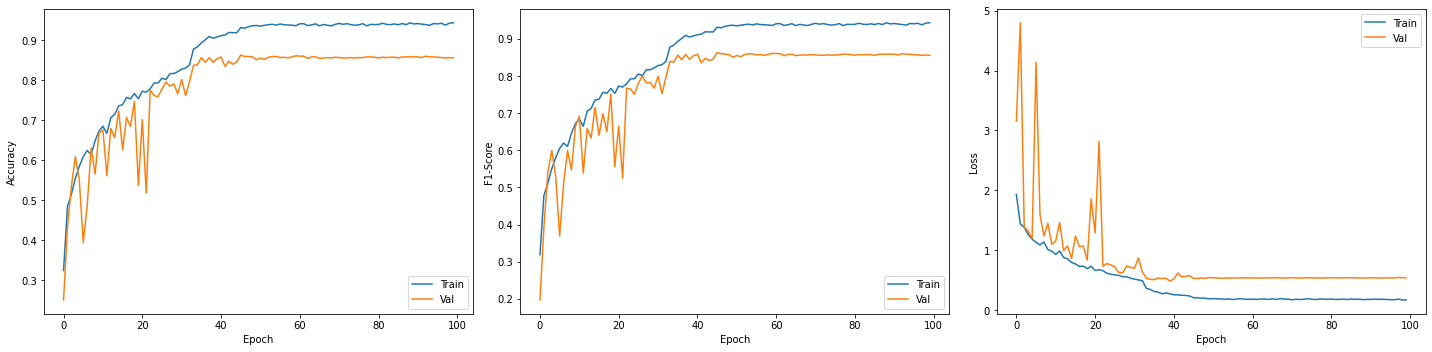

In [50]:
figpath = r"figures\final_model_results.pdf"
fig = plt.figure(figsize = (20, 5))
hist_dict = hist_dict.history
    
plt.subplot(1, 3, 1)
plt.plot(hist_dict["accuracy"], label="Train")
plt.plot(hist_dict["val_accuracy"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 3, 2)
plt.plot(hist_dict["f1_score"], label="Train")
plt.plot(hist_dict["val_f1_score"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(hist_dict["loss"], label="Train")
plt.plot(hist_dict["val_loss"], label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig(figpath)
plt.show()

The best model performance was achieved in epoch 46 with a validation f1-score of 86.3%. Awesome!

# Evaluate Final Model on Test Set

In [12]:
model_path = r"model\best_model"
model = tf.keras.models.load_model(model_path)

# create test generator 
datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
generator_test = datagen_test.flow_from_dataframe(df_test,
                                                  directory="dataset",
                                                  x_col="filepath",
                                                  y_col="label",
                                                  target_size=(256, 256),
                                                  color_mode="rgb",
                                                  class_mode="categorical",
                                                  batch_size=16,
                                                  shuffle=False)

# run the model on the hold-out test set
test_results_dict = model.evaluate(x=generator_test, verbose=1, return_dict=True)

Found 1373 validated image filenames belonging to 11 classes.
86/86 [==============================] - 21s 146ms/step - loss: 0.2483 - accuracy: 0.9308 - f1_score: 0.9303


Perfect! The model has a very good performance on the hold-out test set. 

# Labels to File
Let's store the mapping from index to label in a json file to be able to map the network output correctly later!

In [14]:
labels = generator_test.class_indices
labels = dict((v,k) for k,v in labels.items())

In [15]:
labels

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

In [16]:
import json

with open("index_to_label.json", "w+") as json_file:
    json.dump(labels, json_file)